In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Creating multiple dataframe with different "look back" periods
# The periods are 1 day, 3 days. 7 days. 15 days. 30 days and 60 days
# The look back periods should be in the form of a list
# For example, if the look back period is 3, then the dataframe should have 3 columns
# Date, Close, [Close(t-1), Close(t-2), Close(t-3)]

def create_look_back_arrays(df, window_size = 1):
    df = df.drop(columns = ['Date'])
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i+window_size])
        Y.append(df_as_np[i+window_size])
    return np.array(X), np.array(Y)

In [3]:
df = pd.read_csv('../Data/ethereum_data.csv')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
1660,2022-05-27,1802.543823,1814.656494,1721.264771,1724.922852,1724.922852,25470760032
1661,2022-05-28,1724.635986,1757.941772,1724.635986,1757.941772,1757.941772,23214777872
1662,2022-05-29,1792.184448,1818.776611,1765.937378,1812.031006,1812.031006,10642556101
1663,2022-05-30,1811.885986,2005.210815,1804.456055,1996.441284,1996.441284,19580808705


In [5]:
df = df[['Date', 'Close']]

In [6]:
df

,Date,Close
0,2017-11-09,320.884003
1,2017-11-10,299.252991
2,2017-11-11,314.681000
3,2017-11-12,307.907990
4,2017-11-13,316.716003
...,...,...
1660,2022-05-27,1724.922852
1661,2022-05-28,1757.941772
1662,2022-05-29,1812.031006
1663,2022-05-30,1996.441284


In [7]:
# Scale the values in the Close column
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

/var/folders/76/w363ly_90ln6pf3txlrc64bw0000gn/T/ipykernel_28885/3875126601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


In [8]:
df

,Date,Close
0,2017-11-09,0.050040
1,2017-11-10,0.045464
2,2017-11-11,0.048727
3,2017-11-12,0.047295
4,2017-11-13,0.049158
...,...,...
1660,2022-05-27,0.347016
1661,2022-05-28,0.354000
1662,2022-05-29,0.365441
1663,2022-05-30,0.404446


In [9]:
x_1, y_1 = create_look_back_arrays(df, 1)
x_3, y_3 = create_look_back_arrays(df, 3)
x_7, y_7 = create_look_back_arrays(df, 7)
x_15, y_15 = create_look_back_arrays(df, 15)
x_30, y_30 = create_look_back_arrays(df, 30)
x_60, y_60 = create_look_back_arrays(df, 60)

# 1 Day look back window

In [10]:
x_1.shape, y_1.shape

((1664, 1, 1), (1664, 1))

In [11]:
X_1_train, y_1_train = x_1[:1300], y_1[:1300]
X_1_val, y_1_val = x_1[1300:1500], y_1[1300:1500]
X_1_test, y_1_test = x_1[1500:], y_1[1500:]
X_1_train.shape, y_1_train.shape, X_1_val.shape, y_1_val.shape, X_1_test.shape, y_1_test.shape

((1300, 1, 1), (1300, 1), (200, 1, 1), (200, 1), (164, 1, 1), (164, 1))

In [12]:
model_1 = Sequential()
model_1.add(InputLayer(input_shape = (1, 1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, activation = 'relu'))
model_1.add(Dense(1, activation = 'linear'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
cp = ModelCheckpoint('models/lstm_1.h5', save_best_only = True)
model_1.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [14]:
model_1.fit(X_1_train, y_1_train, epochs = 200, validation_data = (X_1_val, y_1_val), callbacks = [cp])

Epoch 1/200
41/41 [==============================] - 1s 6ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - mean_absolute_error: 0.0890 - val_loss: 0.4618 - val_root_mean_squared_error: 0.6795 - val_mean_absolute_error: 0.6559
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0236 - root_mean_squared_error: 0.1537 - mean_absolute_error: 0.0799 - val_loss: 0.4406 - val_root_mean_squared_error: 0.6638 - val_mean_absolute_error: 0.6399
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0218 - root_mean_squared_error: 0.1475 - mean_absolute_error: 0.0742 - val_loss: 0.4210 - val_root_mean_squared_error: 0.6488 - val_mean_absolute_error: 0.6249
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0202 - root_mean_squared_error: 0.1422 - mean_absolute_error: 0.0719 - val_loss: 0.4025 - val_root_mean_squared_error: 0.6344 - val_mean_absolute_error: 0.6103
Epoch 5/200
 1/41 [..............................] - ETA: 0s

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 1ms/step - loss: 0.0189 - root_mean_squared_error: 0.1376 - mean_absolute_error: 0.0715 - val_loss: 0.3851 - val_root_mean_squared_error: 0.6205 - val_mean_absolute_error: 0.5963
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0179 - root_mean_squared_error: 0.1337 - mean_absolute_error: 0.0717 - val_loss: 0.3689 - val_root_mean_squared_error: 0.6074 - val_mean_absolute_error: 0.5830
Epoch 7/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - mean_absolute_error: 0.0725 - val_loss: 0.3534 - val_root_mean_squared_error: 0.5945 - val_mean_absolute_error: 0.5701
Epoch 8/200
41/41 [==============================] - 0s 1ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - mean_absolute_error: 0.0734 - val_loss: 0.3402 - val_root_mean_squared_error: 0.5832 - val_mean_absolute_error: 0.5588
Epoch 9/200
41/41 [==============================] - 0s 1ms/step - loss:

In [15]:
model_1 = load_model('models/lstm_1.h5')

In [16]:
test_1_predictions = model_1.predict(X_1_test)
test_results = pd.DataFrame({'Actual': y_1_test.flatten(), 'Predicted': test_1_predictions.flatten()})
test_results

6/6 [==============================] - 0s 635us/step


,Actual,Predicted
0,0.811858,0.817418
1,0.814238,0.809225
2,0.832516,0.811633
3,0.824444,0.830152
4,0.851078,0.821968
...,...,...
159,0.347016,0.369822
160,0.354000,0.353927
161,0.365441,0.360564
162,0.404446,0.371460


In [17]:
# Creating a dataframe with the actual and predicted values without the scaling 
test_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1501:].flatten(), 'Predicted': scaler.inverse_transform(test_1_predictions).flatten()})
test_results_unscaled

,Actual,Predicted
0,3922.592529,3948.878906
1,3933.844482,3910.146484
2,4020.260010,3921.530762
3,3982.099609,4009.082764
4,4108.015625,3970.393311
...,...,...
159,1724.922852,1832.746826
160,1757.941772,1757.596558
161,1812.031006,1788.973145
162,1996.441284,1840.487183


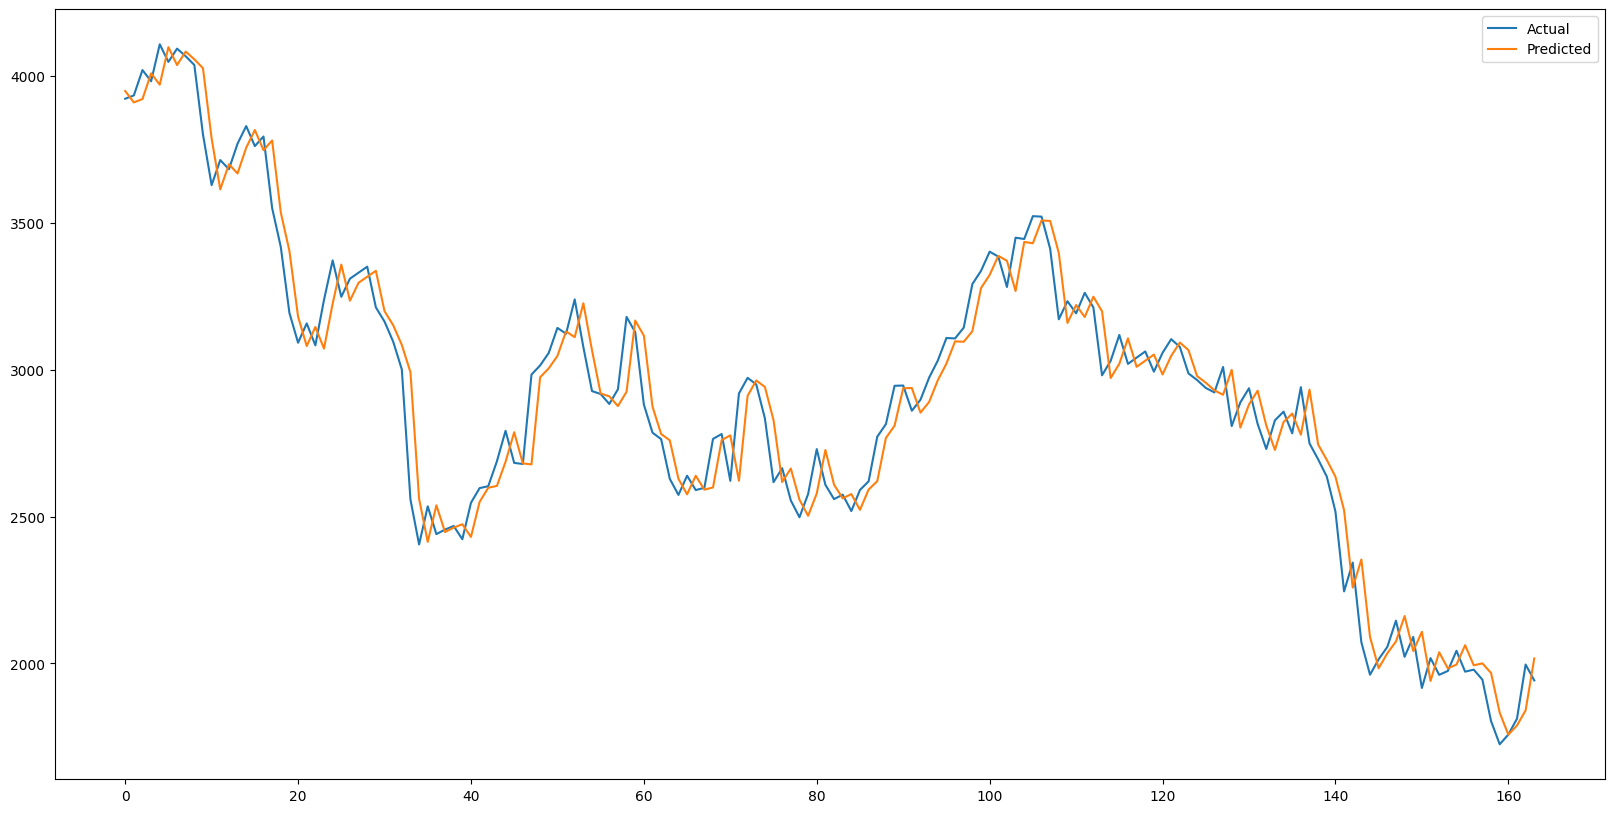

In [18]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [19]:
# Calculating the RMSE and MAE
rmse = np.sqrt(np.mean((test_results_unscaled['Actual'] - test_results_unscaled['Predicted'])**2))
mae = np.mean(np.abs(test_results_unscaled['Actual'] - test_results_unscaled['Predicted']))
rmse, mae

(112.6389308622463, 87.62405618807166)

# 3 Day Look Back Window

In [20]:
x_3.shape, y_3.shape

((1662, 3, 1), (1662, 1))

In [21]:
X_3_train, y_3_train = x_3[:1300], y_3[:1300]
X_3_val, y_3_val = x_3[1300:1500], y_3[1300:1500]
X_3_test, y_3_test = x_3[1500:], y_3[1500:]
X_3_train.shape, y_3_train.shape, X_3_val.shape, y_3_val.shape, X_3_test.shape, y_3_test.shape

((1300, 3, 1), (1300, 1), (200, 3, 1), (200, 1), (162, 3, 1), (162, 1))

In [22]:
model_3 = Sequential()
model_3.add(InputLayer(input_shape = (3, 1)))
model_3.add(LSTM(64))
model_3.add(Dense(8, activation = 'relu'))
model_3.add(Dense(1, activation = 'linear'))

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
cp3 = ModelCheckpoint('models/lstm_3.h5', save_best_only = True)
model_3.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [24]:
model_3.fit(X_3_train, y_3_train, epochs = 200, validation_data = (X_3_val, y_3_val), callbacks = [cp3])

Epoch 1/200
41/41 [==============================] - 1s 6ms/step - loss: 0.0273 - root_mean_squared_error: 0.1651 - mean_absolute_error: 0.0910 - val_loss: 0.4717 - val_root_mean_squared_error: 0.6868 - val_mean_absolute_error: 0.6627
Epoch 2/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0230 - root_mean_squared_error: 0.1518 - mean_absolute_error: 0.0774 - val_loss: 0.4212 - val_root_mean_squared_error: 0.6490 - val_mean_absolute_error: 0.6250
Epoch 3/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0197 - root_mean_squared_error: 0.1405 - mean_absolute_error: 0.0728 - val_loss: 0.3777 - val_root_mean_squared_error: 0.6145 - val_mean_absolute_error: 0.5908
Epoch 4/200
 1/41 [..............................] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0648 - mean_absolute_error: 0.0465

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 2ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - mean_absolute_error: 0.0725 - val_loss: 0.3368 - val_root_mean_squared_error: 0.5804 - val_mean_absolute_error: 0.5562
Epoch 5/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0150 - root_mean_squared_error: 0.1226 - mean_absolute_error: 0.0743 - val_loss: 0.2837 - val_root_mean_squared_error: 0.5326 - val_mean_absolute_error: 0.5091
Epoch 6/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - mean_absolute_error: 0.0752 - val_loss: 0.2467 - val_root_mean_squared_error: 0.4967 - val_mean_absolute_error: 0.4741
Epoch 7/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - mean_absolute_error: 0.0739 - val_loss: 0.2154 - val_root_mean_squared_error: 0.4641 - val_mean_absolute_error: 0.4427
Epoch 8/200
41/41 [==============================] - 0s 2ms/step - loss:

In [25]:
model_3 = load_model('models/lstm_3.h5')

In [26]:
test_3_predictions = model_3.predict(X_3_test)
test_3_results = pd.DataFrame({'Actual': y_3_test.flatten(), 'Predicted': test_3_predictions.flatten()})
test_3_results

6/6 [==============================] - 0s 704us/step


,Actual,Predicted
0,0.832516,0.807979
1,0.824444,0.809528
2,0.851078,0.814360
3,0.838380,0.824917
4,0.847961,0.827180
...,...,...
157,0.347016,0.397296
158,0.354000,0.379803
159,0.365441,0.362550
160,0.404446,0.360340


In [27]:
# Creating a dataframe with the actual and predicted values without the scaling
test_3_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1503:].flatten(), 'Predicted': scaler.inverse_transform(test_3_predictions).flatten()})

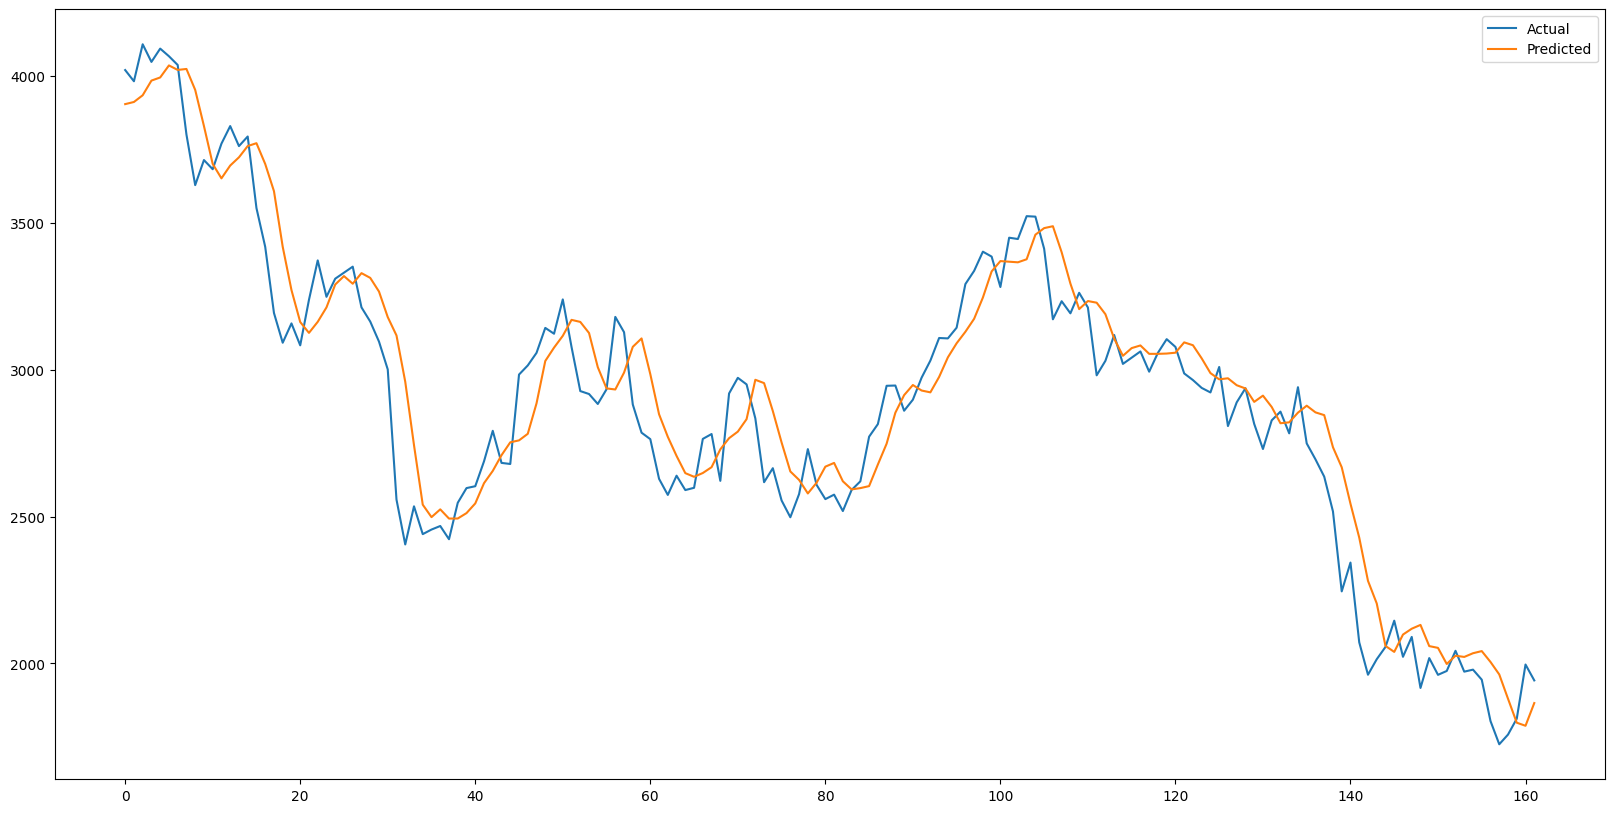

In [28]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_3_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_3_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [29]:
# Calculating the RMSE and MAE
rmse_3 = np.sqrt(np.mean((test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted'])**2))
mae_3 = np.mean(np.abs(test_3_results_unscaled['Actual'] - test_3_results_unscaled['Predicted']))
rmse_3, mae_3

(159.67188159386632, 125.03273368176119)

# 7 Day Look Back Window

In [30]:
x_7.shape, y_7.shape

((1658, 7, 1), (1658, 1))

In [31]:
X_7_train, y_7_train = x_7[:1300], y_7[:1300]
X_7_val, y_7_val = x_7[1300:1500], y_7[1300:1500]
X_7_test, y_7_test = x_7[1500:], y_7[1500:]
X_7_train.shape, y_7_train.shape, X_7_val.shape, y_7_val.shape, X_7_test.shape, y_7_test.shape

((1300, 7, 1), (1300, 1), (200, 7, 1), (200, 1), (158, 7, 1), (158, 1))

In [32]:
model_7 = Sequential()
model_7.add(InputLayer(input_shape = (7, 1)))
model_7.add(LSTM(64))
model_7.add(Dense(8, activation = 'relu'))
model_7.add(Dense(1, activation = 'linear'))

model_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
cp7 = ModelCheckpoint('models/lstm_7.h5', save_best_only = True)
model_7.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [34]:
model_7.fit(X_7_train, y_7_train, epochs = 200, validation_data = (X_7_val, y_7_val), callbacks = [cp7])

Epoch 1/200
41/41 [==============================] - 1s 9ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - mean_absolute_error: 0.0628 - val_loss: 0.1957 - val_root_mean_squared_error: 0.4423 - val_mean_absolute_error: 0.4249
Epoch 2/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - mean_absolute_error: 0.0478 - val_loss: 0.0983 - val_root_mean_squared_error: 0.3135 - val_mean_absolute_error: 0.2981
Epoch 3/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0037 - root_mean_squared_error: 0.0605 - mean_absolute_error: 0.0390 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2077 - val_mean_absolute_error: 0.1939
Epoch 4/200


/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 2ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - mean_absolute_error: 0.0262 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220 - val_mean_absolute_error: 0.1089
Epoch 5/200
41/41 [==============================] - 0s 2ms/step - loss: 7.0816e-04 - root_mean_squared_error: 0.0266 - mean_absolute_error: 0.0162 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0671 - val_mean_absolute_error: 0.0564
Epoch 6/200
41/41 [==============================] - 0s 2ms/step - loss: 4.5936e-04 - root_mean_squared_error: 0.0214 - mean_absolute_error: 0.0109 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.0409
Epoch 7/200
41/41 [==============================] - 0s 2ms/step - loss: 4.2508e-04 - root_mean_squared_error: 0.0206 - mean_absolute_error: 0.0093 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.0392
Epoch 8/200
41/41 [==============================] - 0s 2ms/

In [35]:
model_7 = load_model('models/lstm_7.h5')

In [36]:
test_7_predictions = model_7.predict(X_7_test)
test_7_results = pd.DataFrame({'Actual': y_7_test.flatten(), 'Predicted': test_7_predictions.flatten()})
test_7_results

5/5 [==============================] - 0s 1ms/step


,Actual,Predicted
0,0.847961,0.824991
1,0.842472,0.829281
2,0.836173,0.829368
3,0.786116,0.826513
4,0.749659,0.807995
...,...,...
153,0.347016,0.396565
154,0.354000,0.380187
155,0.365441,0.371195
156,0.404446,0.370412


In [37]:
# Creating a dataframe with the actual and predicted values without the scaling
test_7_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1507:].flatten(), 'Predicted': scaler.inverse_transform(test_7_predictions).flatten()})

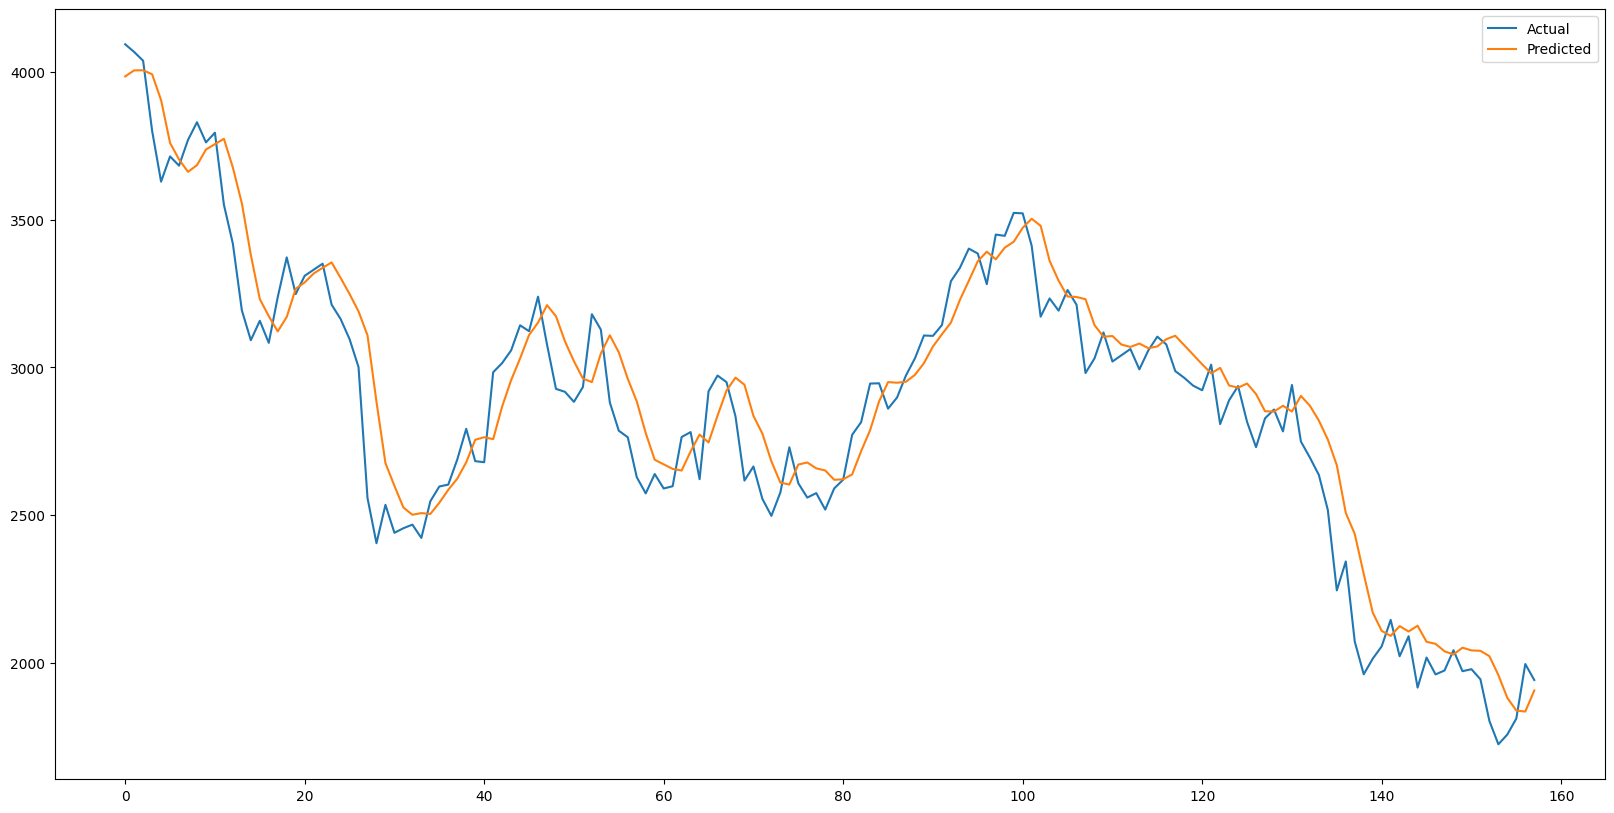

In [38]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_7_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_7_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [39]:
rmse_7 = np.sqrt(np.mean((test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted'])**2))
mae_7 = np.mean(np.abs(test_7_results_unscaled['Actual'] - test_7_results_unscaled['Predicted']))
rmse_7, mae_7

(151.87669629909234, 118.42430327210245)

# 15 Day Look Back Window

In [40]:
x_15.shape, y_15.shape

((1650, 15, 1), (1650, 1))

In [41]:
X_15_train, y_15_train = x_15[:1300], y_15[:1300]
X_15_val, y_15_val = x_15[1300:1500], y_15[1300:1500]
X_15_test, y_15_test = x_15[1500:], y_15[1500:]
X_15_train.shape, y_15_train.shape, X_15_val.shape, y_15_val.shape, X_15_test.shape, y_15_test.shape

((1300, 15, 1), (1300, 1), (200, 15, 1), (200, 1), (150, 15, 1), (150, 1))

In [42]:
model_15 = Sequential()
model_15.add(InputLayer(input_shape = (15, 1)))
model_15.add(LSTM(64))
model_15.add(Dense(8, activation = 'relu'))
model_15.add(Dense(1, activation = 'linear'))

model_15.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
cp15 = ModelCheckpoint('models/lstm_15.h5', save_best_only = True)
model_15.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [44]:
model_15.fit(X_15_train, y_15_train, epochs = 200, validation_data = (X_15_val, y_15_val), callbacks = [cp15])

Epoch 1/200
41/41 [==============================] - 1s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - mean_absolute_error: 0.0697 - val_loss: 0.2303 - val_root_mean_squared_error: 0.4799 - val_mean_absolute_error: 0.4618
Epoch 2/200
41/41 [==============================] - 0s 4ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - mean_absolute_error: 0.0521 - val_loss: 0.1095 - val_root_mean_squared_error: 0.3310 - val_mean_absolute_error: 0.3147
Epoch 3/200
 1/41 [..............................] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0380

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 4ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - mean_absolute_error: 0.0484 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1946 - val_mean_absolute_error: 0.1796
Epoch 4/200
41/41 [==============================] - 0s 4ms/step - loss: 0.0023 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0364 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928 - val_mean_absolute_error: 0.0775
Epoch 5/200
41/41 [==============================] - 0s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - mean_absolute_error: 0.0231 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.0540
Epoch 6/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - mean_absolute_error: 0.0166 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670 - val_mean_absolute_error: 0.0561
Epoch 7/200
41/41 [==============================] - 0s 3ms/step - loss:

In [45]:
model_15 = load_model('models/lstm_15.h5')

In [46]:
test_15_predictions = model_15.predict(X_15_test)
test_15_results = pd.DataFrame({'Actual': y_15_test.flatten(), 'Predicted': test_15_predictions.flatten()})
test_15_results

5/5 [==============================] - 0s 1ms/step


,Actual,Predicted
0,0.792181,0.753427
1,0.777759,0.751404
2,0.784670,0.748344
3,0.733130,0.747647
4,0.705215,0.740039
...,...,...
145,0.347016,0.424451
146,0.354000,0.415536
147,0.365441,0.408169
148,0.404446,0.403469


In [47]:
# Creating a dataframe with the actual and predicted values without the scaling
test_15_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1515:].flatten(), 'Predicted': scaler.inverse_transform(test_15_predictions).flatten()})

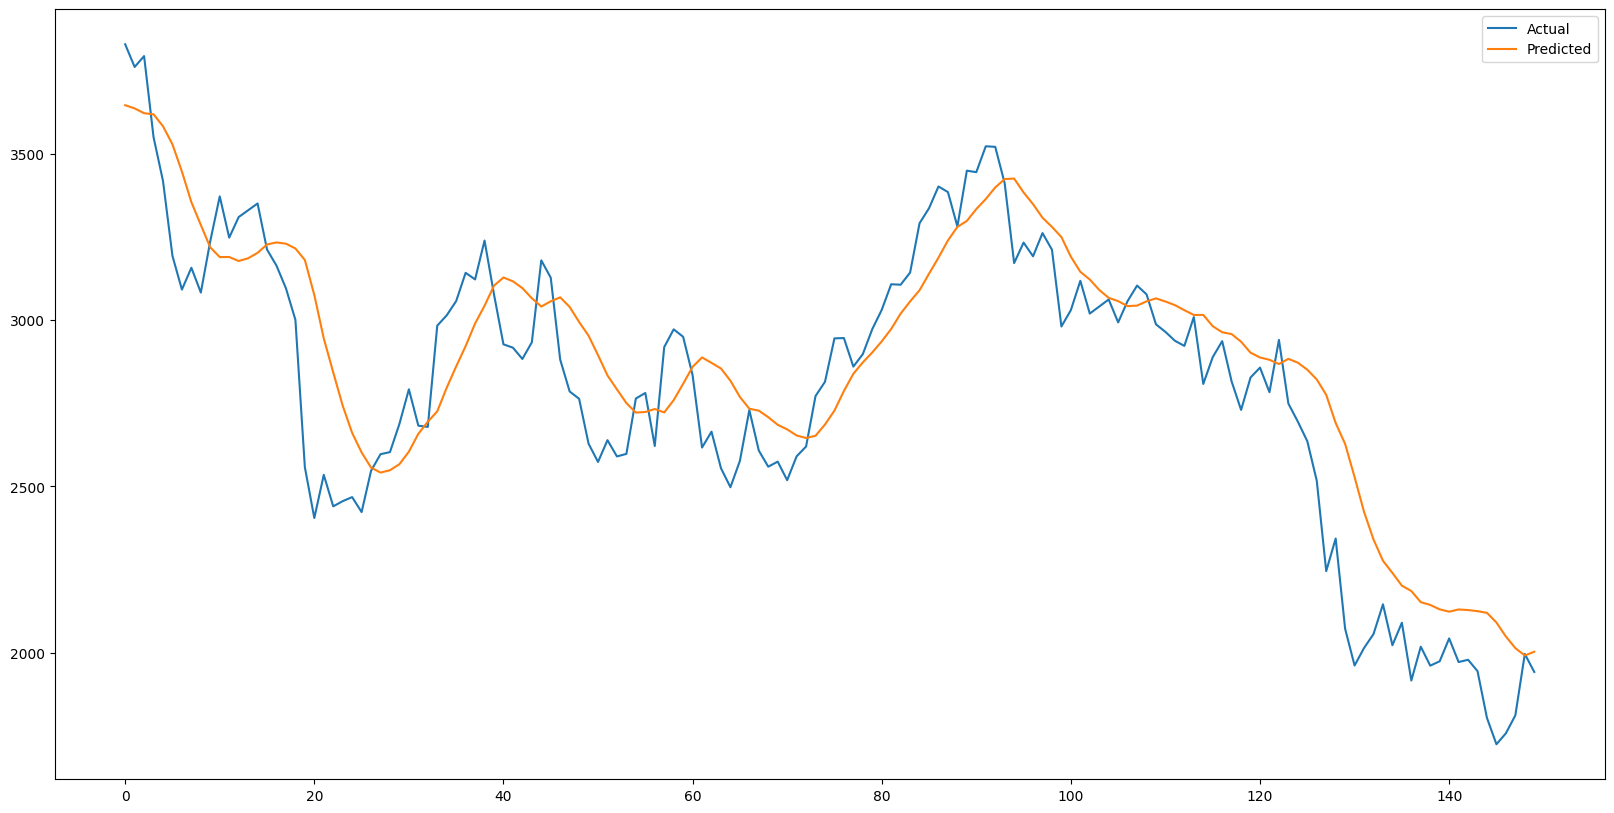

In [48]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_15_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_15_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [49]:
rmse_15 = np.sqrt(np.mean((test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted'])**2))
mae_15 = np.mean(np.abs(test_15_results_unscaled['Actual'] - test_15_results_unscaled['Predicted']))
rmse_15, mae_15

(205.48863243894115, 164.75404052734376)

# 30 Day Look Back Window

In [50]:
x_30.shape, y_30.shape

((1635, 30, 1), (1635, 1))

In [51]:
X_30_train, y_30_train = x_30[:1300], y_30[:1300]
X_30_val, y_30_val = x_30[1300:1500], y_30[1300:1500]
X_30_test, y_30_test = x_30[1500:], y_30[1500:]
X_30_train.shape, y_30_train.shape, X_30_val.shape, y_30_val.shape, X_30_test.shape, y_30_test.shape

((1300, 30, 1), (1300, 1), (200, 30, 1), (200, 1), (135, 30, 1), (135, 1))

In [52]:
model_30 = Sequential()
model_30.add(InputLayer(input_shape = (30, 1)))
model_30.add(LSTM(64))
model_30.add(Dense(8, activation = 'relu'))
model_30.add(Dense(1, activation = 'linear'))

model_30.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
cp30 = ModelCheckpoint('models/lstm_30.h5', save_best_only = True)
model_30.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [54]:
model_30.fit(X_30_train, y_30_train, epochs = 200, validation_data = (X_30_val, y_30_val), callbacks = [cp30])

Epoch 1/200
41/41 [==============================] - 1s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - mean_absolute_error: 0.0647 - val_loss: 0.1650 - val_root_mean_squared_error: 0.4062 - val_mean_absolute_error: 0.3925
Epoch 2/200
31/41 [=====================>........] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0810 - mean_absolute_error: 0.0551

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - mean_absolute_error: 0.0538 - val_loss: 0.0512 - val_root_mean_squared_error: 0.2263 - val_mean_absolute_error: 0.2139
Epoch 3/200
41/41 [==============================] - 0s 6ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485 - mean_absolute_error: 0.0366 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857 - val_mean_absolute_error: 0.0707
Epoch 4/200
41/41 [==============================] - 0s 6ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - mean_absolute_error: 0.0163 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0638 - val_mean_absolute_error: 0.0536
Epoch 5/200
41/41 [==============================] - 0s 6ms/step - loss: 8.7456e-04 - root_mean_squared_error: 0.0296 - mean_absolute_error: 0.0141 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628 - val_mean_absolute_error: 0.0523
Epoch 6/200
41/41 [==============================] - 0s 6ms/step - l

In [55]:
model_30 = load_model('models/lstm_30.h5')

In [56]:
test_30_predictions = model_30.predict(X_30_test)
test_30_results = pd.DataFrame({'Actual': y_30_test.flatten(), 'Predicted': test_30_predictions.flatten()})
test_30_results

5/5 [==============================] - 0s 2ms/step


,Actual,Predicted
0,0.661621,0.710307
1,0.651409,0.696767
2,0.636984,0.678668
3,0.616952,0.657238
4,0.523210,0.632628
...,...,...
130,0.347016,0.394345
131,0.354000,0.374604
132,0.365441,0.364853
133,0.404446,0.365192


In [57]:
# Creating a dataframe with the actual and predicted values without the scaling
test_30_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1530:].flatten(), 'Predicted': scaler.inverse_transform(test_30_predictions).flatten()})

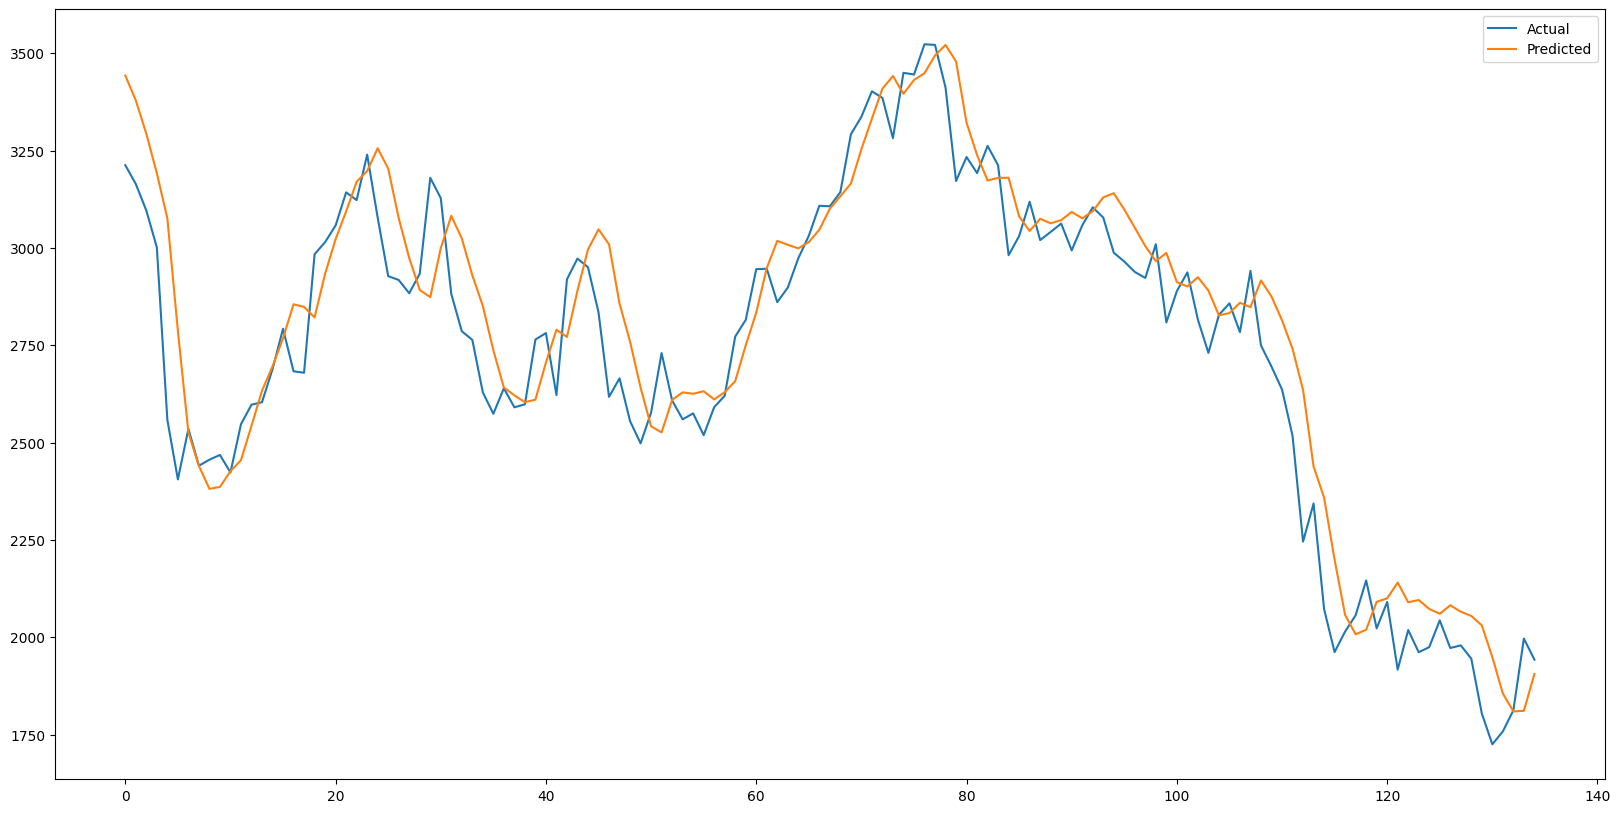

In [58]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_30_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_30_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [59]:
rmse_30 = np.sqrt(np.mean((test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted'])**2))
mae_30 = np.mean(np.abs(test_30_results_unscaled['Actual'] - test_30_results_unscaled['Predicted']))
rmse_30, mae_30

(144.42643344151298, 110.14871690538196)

# 60 Day Look Back Window

In [60]:
x_60.shape, y_60.shape

((1605, 60, 1), (1605, 1))

In [61]:
X_60_train, y_60_train = x_60[:1300], y_60[:1300]
X_60_val, y_60_val = x_60[1300:1500], y_60[1300:1500]
X_60_test, y_60_test = x_60[1500:], y_60[1500:]
X_60_train.shape, y_60_train.shape, X_60_val.shape, y_60_val.shape, X_60_test.shape, y_60_test.shape

((1300, 60, 1), (1300, 1), (200, 60, 1), (200, 1), (105, 60, 1), (105, 1))

In [62]:
model_60 = Sequential()
model_60.add(InputLayer(input_shape = (60, 1)))
model_60.add(LSTM(64))
model_60.add(Dense(8, activation = 'relu'))
model_60.add(Dense(1, activation = 'linear'))

model_60.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
cp60 = ModelCheckpoint('models/lstm_60.h5', save_best_only = True)
model_60.compile(optimizer = Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [64]:
model_60.fit(X_60_train, y_60_train, epochs = 200, validation_data = (X_60_val, y_60_val), callbacks = [cp60])

Epoch 1/200
41/41 [==============================] - 1s 15ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - mean_absolute_error: 0.0702 - val_loss: 0.1479 - val_root_mean_squared_error: 0.3846 - val_mean_absolute_error: 0.3756
Epoch 2/200
18/41 [============>.................] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0820 - mean_absolute_error: 0.0533

/opt/miniconda3/envs/eth/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 11ms/step - loss: 0.0047 - root_mean_squared_error: 0.0682 - mean_absolute_error: 0.0485 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117 - val_mean_absolute_error: 0.0964
Epoch 3/200
41/41 [==============================] - 0s 11ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - mean_absolute_error: 0.0246 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777 - val_mean_absolute_error: 0.0660
Epoch 4/200
41/41 [==============================] - 0s 11ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - mean_absolute_error: 0.0157 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0834 - val_mean_absolute_error: 0.0679
Epoch 5/200
41/41 [==============================] - 0s 11ms/step - loss: 9.6108e-04 - root_mean_squared_error: 0.0310 - mean_absolute_error: 0.0150 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0718 - val_mean_absolute_error: 0.0600
Epoch 6/200
41/41 [==============================] - 0s 11ms/ste

In [65]:
model_60 = load_model('models/lstm_60.h5')

In [66]:
test_60_predictions = model_60.predict(X_60_test)
test_60_results = pd.DataFrame({'Actual': y_60_test.flatten(), 'Predicted': test_60_predictions.flatten()})

4/4 [==============================] - 0s 3ms/step


In [67]:
# Creating a dataframe with the actual and predicted values without the scaling
test_60_results_unscaled = pd.DataFrame({'Actual': scaler.inverse_transform(df[['Close']])[1560:].flatten(), 'Predicted': scaler.inverse_transform(test_60_predictions).flatten()})
test_60_results_unscaled

,Actual,Predicted
0,3127.830078,3030.162598
1,2881.481934,3106.364990
2,2785.727539,3016.768066
3,2763.701172,2905.795898
4,2628.648438,2828.912842
...,...,...
100,1724.922852,1937.999634
101,1757.941772,1843.399170
102,1812.031006,1803.950806
103,1996.441284,1812.760620


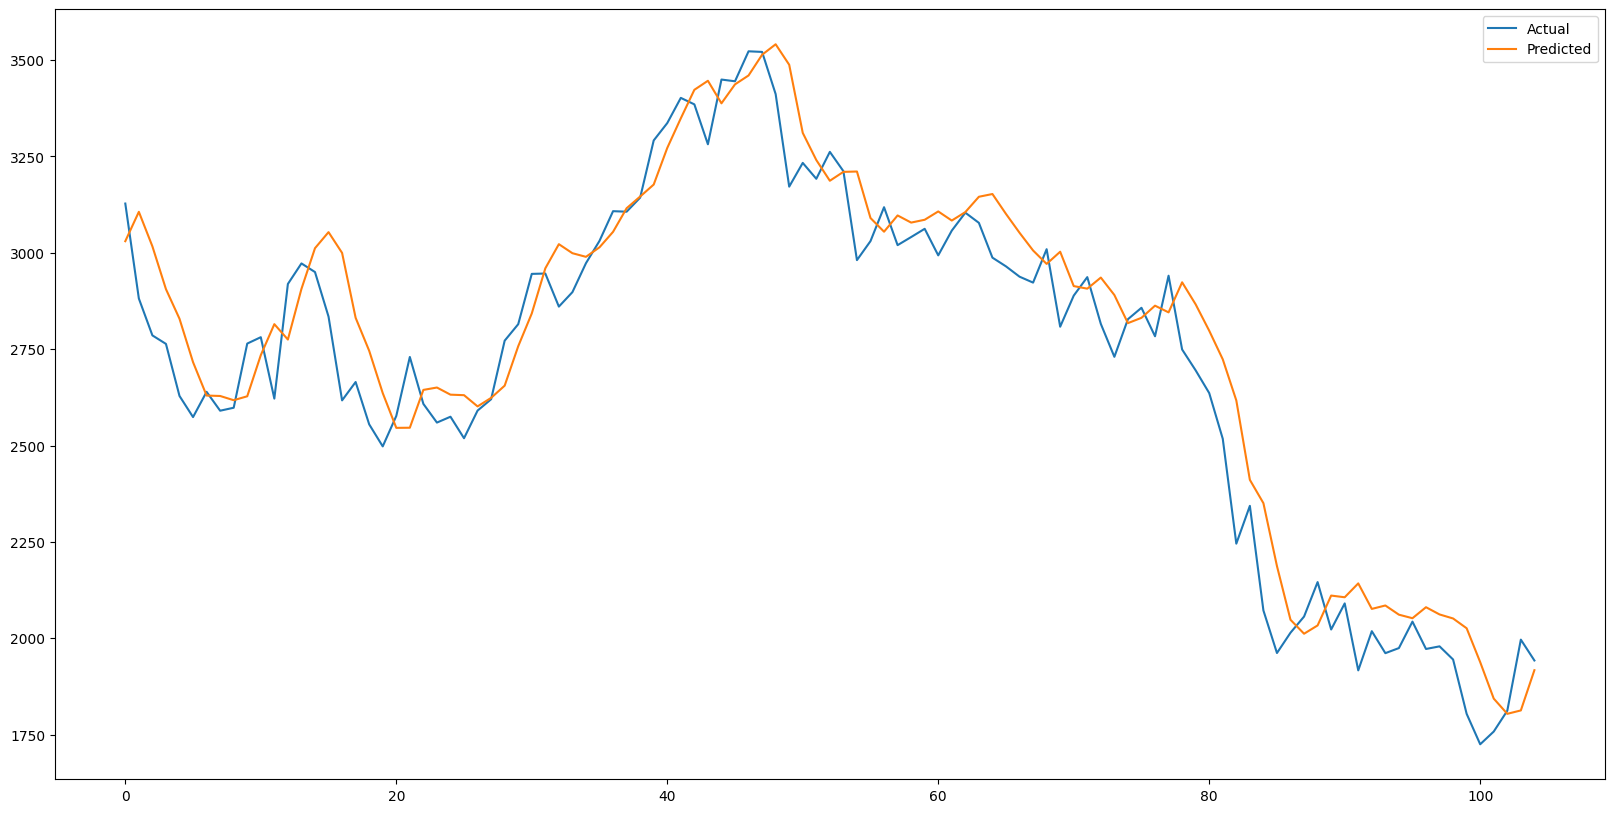

In [68]:
# Plotting the actual and predicted values
plt.figure(figsize = (20, 10))
plt.plot(test_60_results_unscaled['Actual'], label = 'Actual')
plt.plot(test_60_results_unscaled['Predicted'], label = 'Predicted')
plt.legend()

In [69]:
rmse_60 = np.sqrt(np.mean((test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted'])**2))
mae_60 = np.mean(np.abs(test_60_results_unscaled['Actual'] - test_60_results_unscaled['Predicted']))
rmse_60, mae_60

(130.63433561422124, 102.07923758370539)

# Comparing the models 

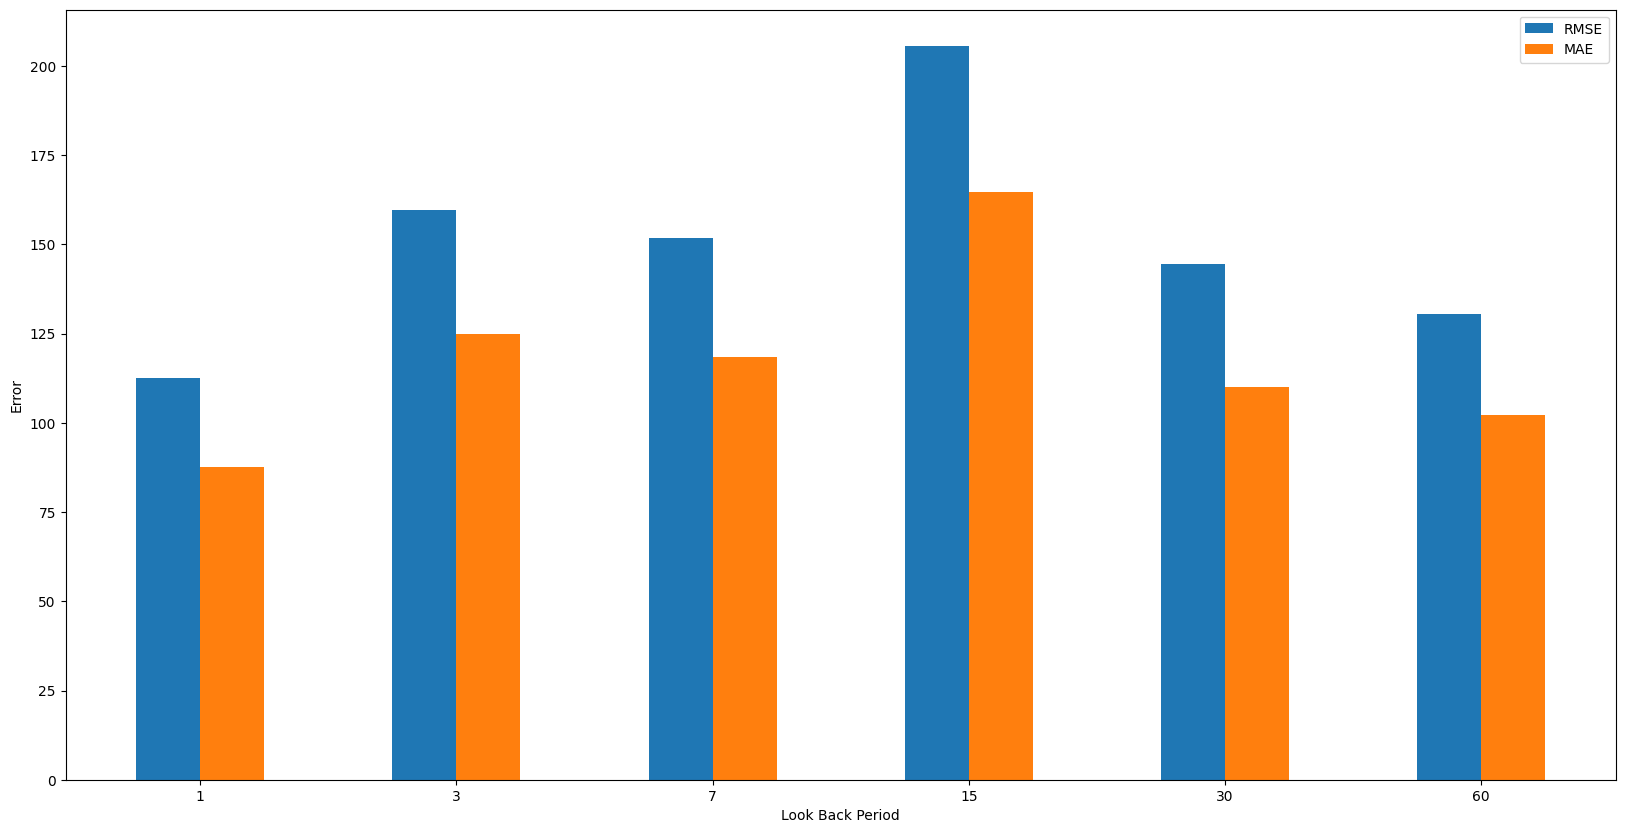

In [70]:
# Plotting in a bar chart, the RMSE and MAE for each look back period. The two metrics are plotted side by side for each look back period
plt.figure(figsize = (20, 10))
plt.bar(np.arange(6), [rmse, rmse_3, rmse_7, rmse_15, rmse_30, rmse_60], width = 0.25, label = 'RMSE')
plt.bar(np.arange(6) + 0.25, [mae, mae_3, mae_7, mae_15, mae_30, mae_60], width = 0.25, label = 'MAE')
plt.xticks(np.arange(6) + 0.125, ['1', '3', '7', '15', '30', '60'])
plt.xlabel('Look Back Period')
plt.ylabel('Error')
plt.legend()